**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
import stumpy

# Data Preparation

In [2]:
df = pd.read_csv('imdb_ts.csv', index_col=0)

In [3]:
df.shape

(1134, 103)

In [4]:
df

0          1          2          3          4          5  \
id                                                                            
tt0062622    57057.0    65469.0    71642.0    73025.0    74060.0    49472.0   
tt0064816     1923.0     2422.0     2853.0     2947.0     3054.0     2844.0   
tt0088178   332925.0   302503.0   267264.0   261879.0   256608.0   196530.0   
tt0145487   682857.0   407032.0    78058.0    81732.0    86772.0    83724.0   
tt0359950  7813372.0  6274563.0  4781588.0  4655046.0  4535301.0  4650574.0   
...              ...        ...        ...        ...        ...        ...   
tt9731534  1077363.0  1061148.0  1043451.0   912840.0   738595.0   508118.0   
tt9735462    56775.0    57750.0    58828.0    53549.0    48484.0    37340.0   
tt9764362  3595005.0  3401235.0  3221227.0  2645775.0  2188725.0  1681250.0   
tt9784798   528167.0   617409.0   696127.0   741481.0   802782.0   527997.0   
tt9883996   260429.0   296061.0   327698.0   265172.0   206614.0   120542.0   

                   6          7          8          9  ...        93  \
id                                                     ...             
tt0062622    30258.0    28036.0    25824.0    32571.0  ...   10709.0   
tt0064816     2617.0     1998.0     1277.0     1449.0  ...     637.0   
tt0088178   112728.0   117384.0   123024.0   119608.0  ...    6784.0   
tt0145487    79940.0    39656.0     6974.0     7697.0  ...   21094.0   
tt0359950  4758452.0  4069428.0  3471755.0  3108057.0  ...   88635.0   
...              ...        ...        ...        ...  ...       ...   
tt9731534   296236.0   318113.0   341113.0   310422.0  ...    2396.0   
tt9735462    19243.0    30804.0    55897.0    40874.0  ...     739.0   
tt9764362  1030698.0  1138724.0  1290788.0  1204996.0  ...  345246.0   
tt9784798   177249.0   141753.0   100026.0    88004.0  ...   10108.0   
tt9883996    63093.0    82683.0    98308.0    85679.0  ...    4851.0   

                 94        95        96        97        98        99  rating  \
id                                                                              
tt0062622   11042.0   11388.0   11847.0   12404.0   13679.0   15056.0     8.3   
tt0064816     734.0     857.0     785.0     724.0     713.0     699.0     7.1   
tt0088178    7253.0    7776.0    9632.0   11212.0    9010.0    6431.0     8.7   
tt0145487   10995.0    1586.0    1421.0    1177.0     970.0     802.0     7.4   
tt0359950   68347.0   45367.0   28915.0   15494.0   16155.0   16853.0     7.3   
...             ...       ...       ...       ...       ...       ...     ...   
tt9731534    2425.0    2461.0    2223.0    1920.0    1991.0    2051.0     6.4   
tt9735462     618.0     488.0     636.0     883.0     904.0     920.0     6.3   
tt9764362  257388.0  182883.0  165311.0  144119.0  128009.0  111756.0     7.2   
tt9784798   10511.0   10878.0    7491.0    3752.0    5237.0    6592.0     7.4   
tt9883996    3427.0    1437.0    1650.0    1826.0    2176.0    2417.0     6.9   

                                       genre  rating_category  
id                                                             
tt0062622            ['Adventure', 'Sci-Fi']             High  
tt0064816      ['Crime', 'Drama', 'Romance']             High  
tt0088178           ['Documentary', 'Music']             High  
tt0145487  ['Action', 'Adventure', 'Sci-Fi']             High  
tt0359950   ['Adventure', 'Comedy', 'Drama']             High  
...                                      ...              ...  
tt9731534  ['Horror', 'Mystery', 'Thriller']           Medium  
tt9735462   ['Biography', 'Comedy', 'Drama']           Medium  
tt9764362   ['Comedy', 'Horror', 'Thriller']             High  
tt9784798  ['Biography', 'Drama', 'History']             High  
tt9883996   ['Biography', 'Comedy', 'Drama']      Medium High  

[1134 rows x 103 columns]

In [5]:
# ---------- Per-series (row-wise) normalization over the first 100 columns ----------
value_cols = [str(i) for i in range(100)]
X = df[value_cols].astype(float).values  # shape (n_series, 100)

row_means = X.mean(axis=1, keepdims=True)
row_stds = X.std(axis=1, ddof=0, keepdims=True)
# avoid division by zero
row_stds[row_stds == 0] = 1.0
X_norm = (X - row_means) / row_stds

df_norm = df.copy()
df_norm[value_cols] = X_norm


# ---------- Motif discovery helper functions (with local subsequence z-normalization) ----------
def z_norm_sliding_windows(ts, m):
    ts = np.asarray(ts, dtype=float)
    n = ts.size
    Xw = np.lib.stride_tricks.sliding_window_view(ts, m)  # shape (n-m+1, m)
    mu = Xw.mean(axis=1, keepdims=True)
    sigma = Xw.std(axis=1, ddof=0, keepdims=True)
    sigma[sigma == 0] = 1.0
    return (Xw - mu) / sigma  # local z-norm

def pairwise_distances(Z):
    norms = np.sum(Z * Z, axis=1, keepdims=True)
    G = Z @ Z.T
    D2 = norms + norms.T - 2 * G
    D2[D2 < 0] = 0.0
    return np.sqrt(D2)

def find_motif_sets_for_series(ts, m=7, max_motifs=3, excl_zone=None):
    if excl_zone is None:
        excl_zone = m // 2
    Z = z_norm_sliding_windows(ts, m)
    k = Z.shape[0]
    D = pairwise_distances(Z)
    # exclusion zone to avoid trivial matches
    for i in range(k):
        lo = max(0, i - excl_zone)
        hi = min(k, i + excl_zone + 1)
        D[i, lo:hi] = np.inf
    np.fill_diagonal(D, np.inf)

    D_work = D.copy()
    motif_sets = []
    for _ in range(3):
        i, j = np.unravel_index(np.argmin(D_work), D_work.shape)
        best = D_work[i, j]
        if not np.isfinite(best):
            break
        r = best * 1.25 + 1e-12
        members = set(np.where(D[i] <= r)[0]) | set(np.where(D[j] <= r)[0]) | {i, j}
        members = sorted(members)
        motif_sets.append({
            "seed_pair": (int(i), int(j)),
            "members": [int(x) for x in members],
            "radius": float(r),
            "seed_distance": float(best)
        })
        # suppress members and neighbors
        for p in members:
            lo = max(0, p - excl_zone)
            hi = min(k, p + excl_zone + 1)
            D_work[p, :] = np.inf
            D_work[:, p] = np.inf
            for q in range(lo, hi):
                D_work[q, :] = np.inf
                D_work[:, q] = np.inf
    return motif_sets

# ---------- Run motif discovery on normalized data ----------
m = 7
max_motifs = 3
ids = df_norm.index.astype(str).tolist()

all_results = {}
summary_rows = []

for row_idx in range(df_norm.shape[0]):
    ts = df_norm.iloc[row_idx][value_cols].values.astype(float)
    motif_sets = find_motif_sets_for_series(ts, m=m, max_motifs=max_motifs)
    all_results[ids[row_idx]] = motif_sets
    row = {"id": ids[row_idx]}
    for k_idx in range(max_motifs):
        if k_idx < len(motif_sets):
            row[f"motif{k_idx+1}_seed"] = motif_sets[k_idx]["seed_pair"]
            row[f"motif{k_idx+1}_members"] = motif_sets[k_idx]["members"]
        else:
            row[f"motif{k_idx+1}_seed"] = None
            row[f"motif{k_idx+1}_members"] = None
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)

In [6]:
summary_df

id motif1_seed motif1_members motif2_seed   motif2_members  \
0     tt0062622     (3, 31)        [3, 31]    (41, 55)         [41, 55]   
1     tt0064816    (41, 70)       [41, 70]     (3, 29)          [3, 29]   
2     tt0088178    (28, 43)       [28, 43]    (16, 89)     [16, 30, 89]   
3     tt0145487    (51, 81)    [8, 51, 81]    (22, 66)     [22, 37, 66]   
4     tt0359950    (64, 93)       [64, 93]    (55, 70)         [55, 70]   
...         ...         ...            ...         ...              ...   
1129  tt9731534     (3, 75)        [3, 75]    (18, 47)  [4, 18, 47, 76]   
1130  tt9735462     (8, 22)        [8, 22]    (81, 93)         [81, 93]   
1131  tt9764362     (3, 17)        [3, 17]    (25, 40)         [25, 40]   
1132  tt9784798    (26, 85)       [26, 85]    (18, 32)         [18, 32]   
1133  tt9883996    (20, 62)       [20, 62]    (30, 45)         [30, 45]   

     motif3_seed motif3_members  
0       (10, 47)   [10, 47, 91]  
1       (16, 47)       [16, 47]  
2       (49, 81)       [49, 81]  
3       (43, 87)       [43, 87]  
4       (21, 80)   [21, 65, 80]  
...          ...            ...  
1129    (12, 70)       [12, 70]  
1130     (1, 15)        [1, 15]  
1131    (29, 44)       [29, 44]  
1132    (37, 51)       [37, 51]  
1133    (53, 83)       [53, 83]  

[1134 rows x 7 columns]

In [7]:
summary_df.to_csv("motifs_df.csv", index=False)


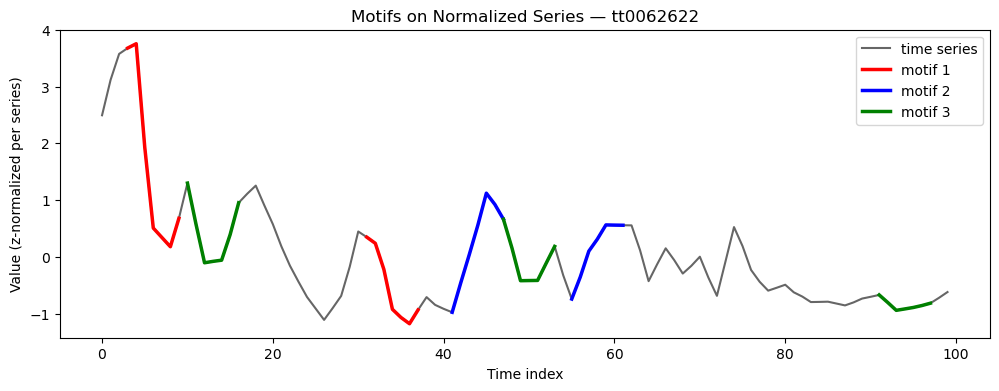

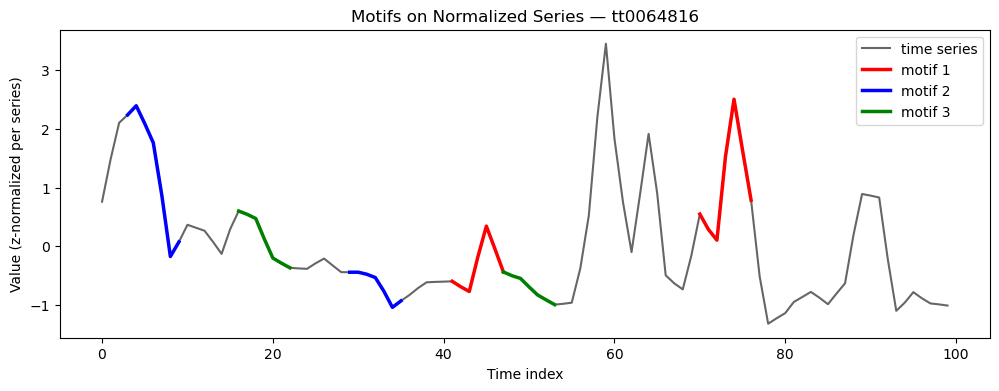

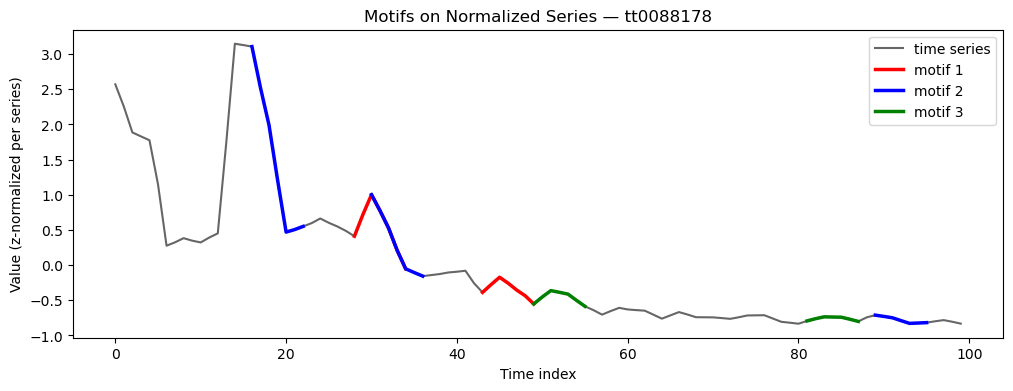

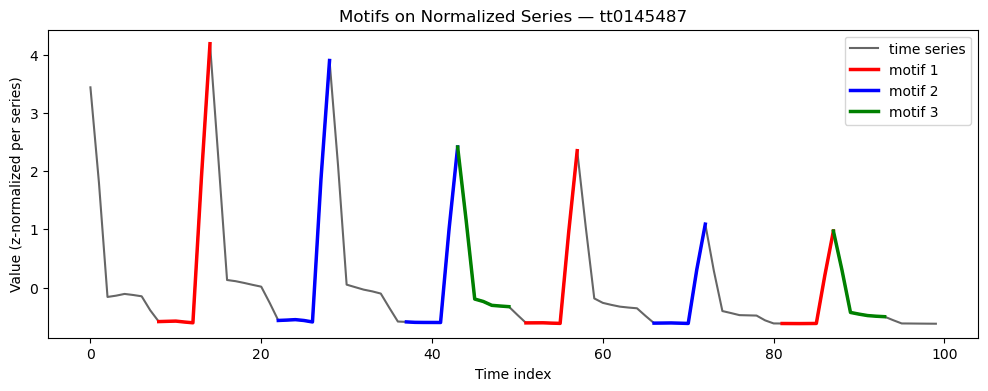

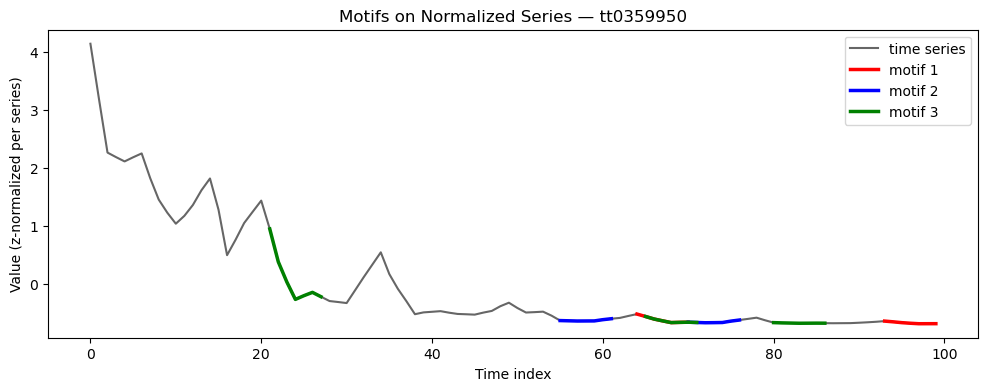

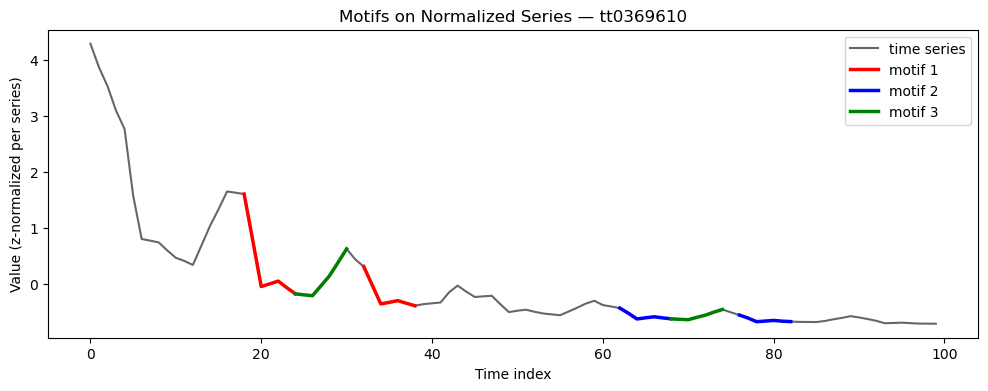

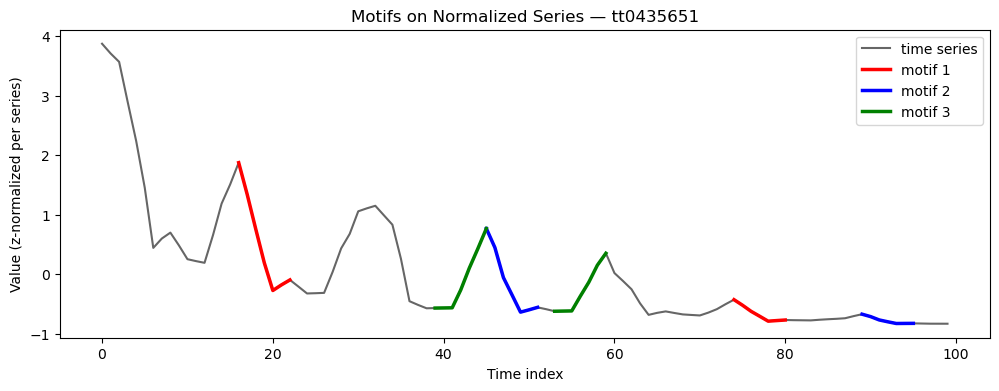

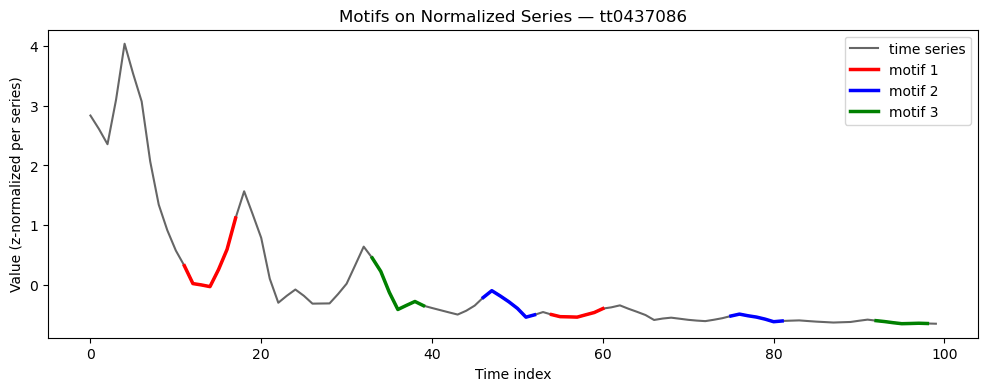

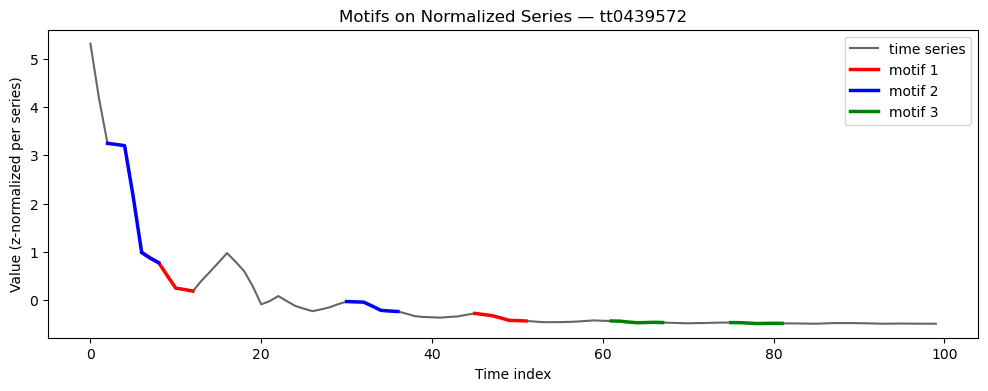

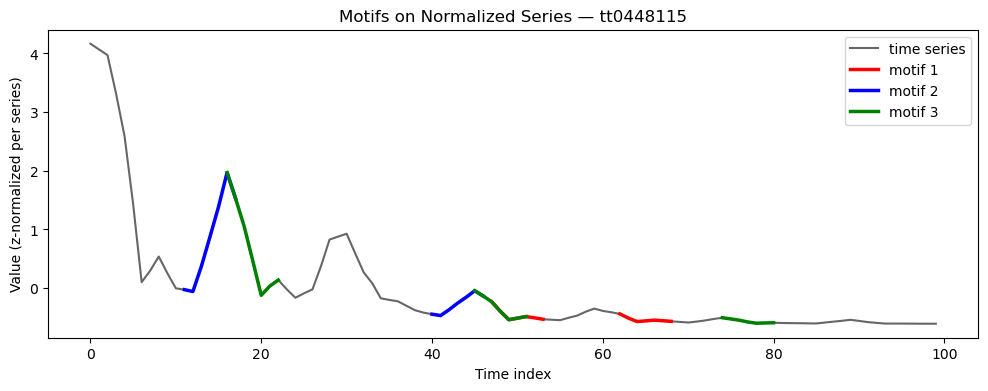

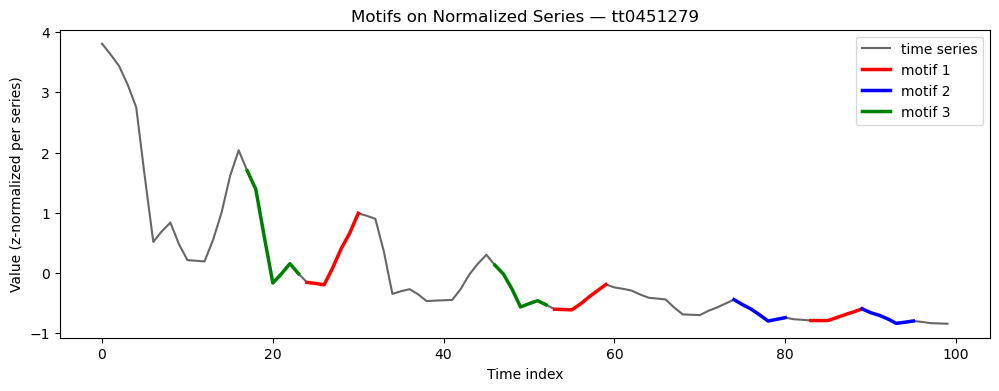

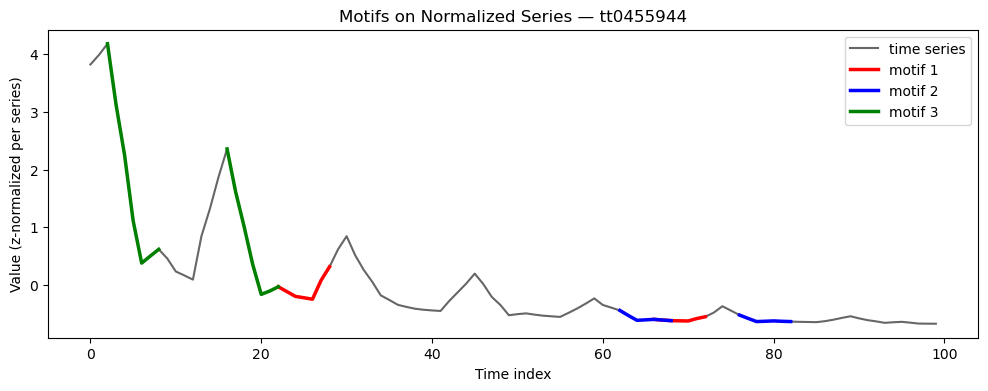

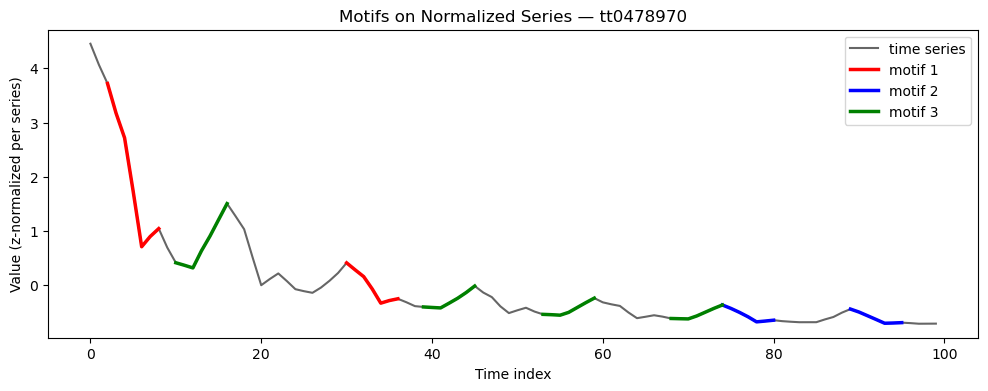

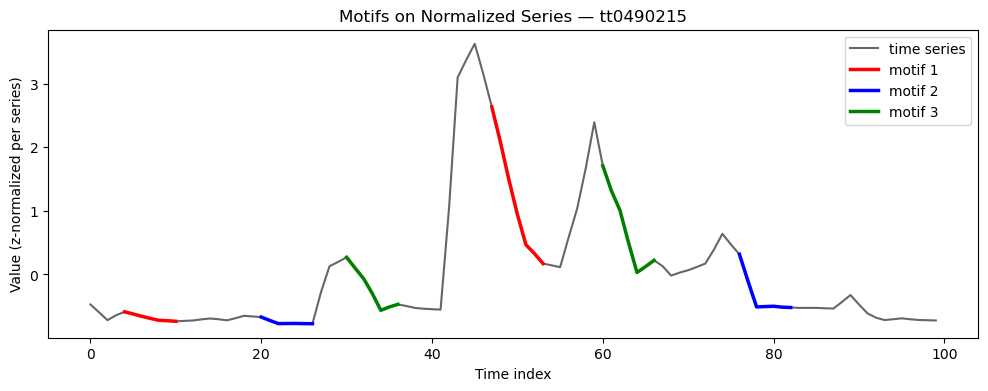

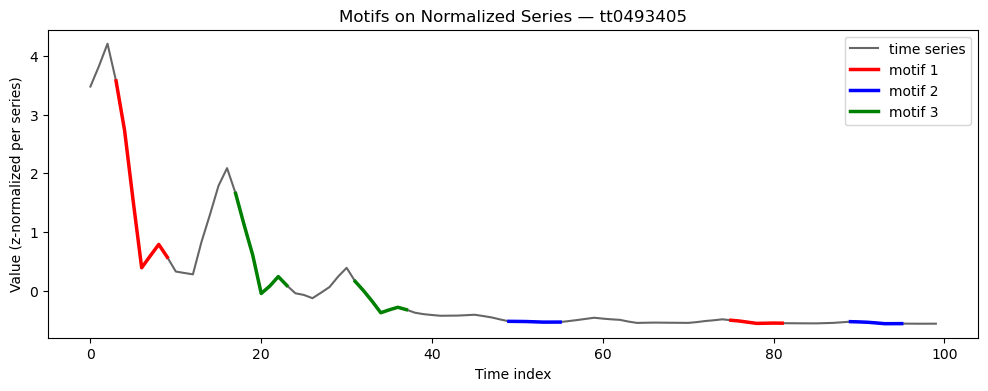

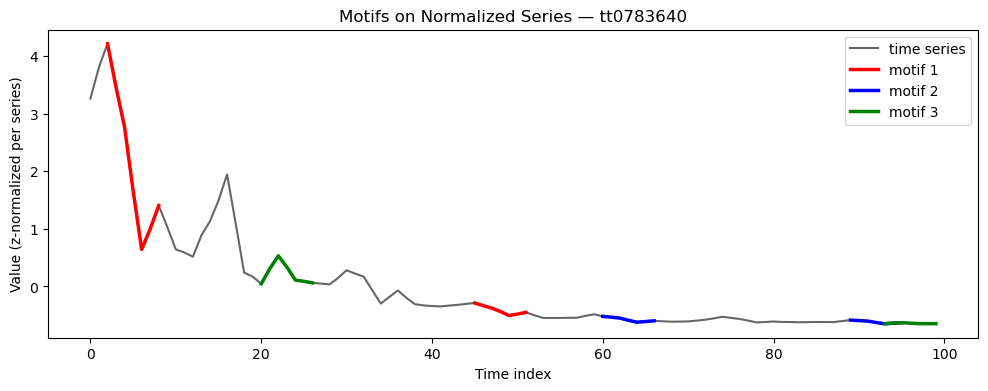

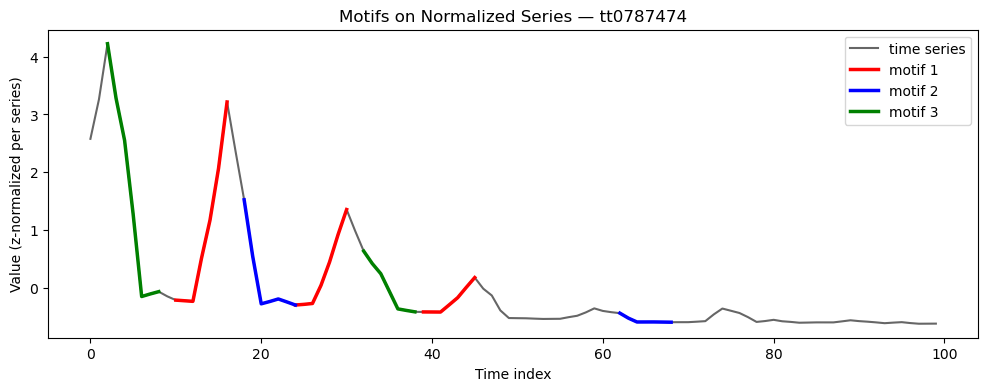

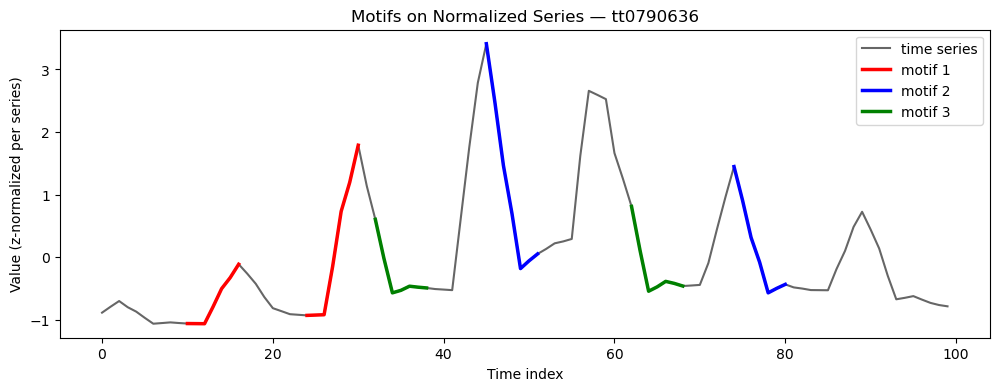

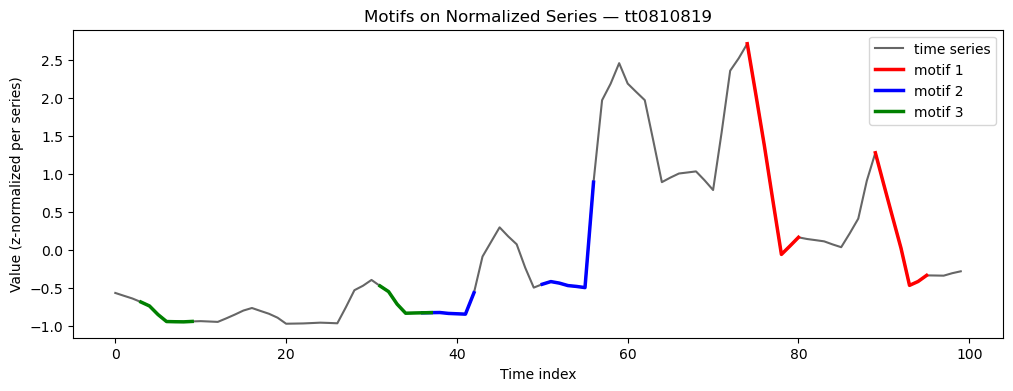

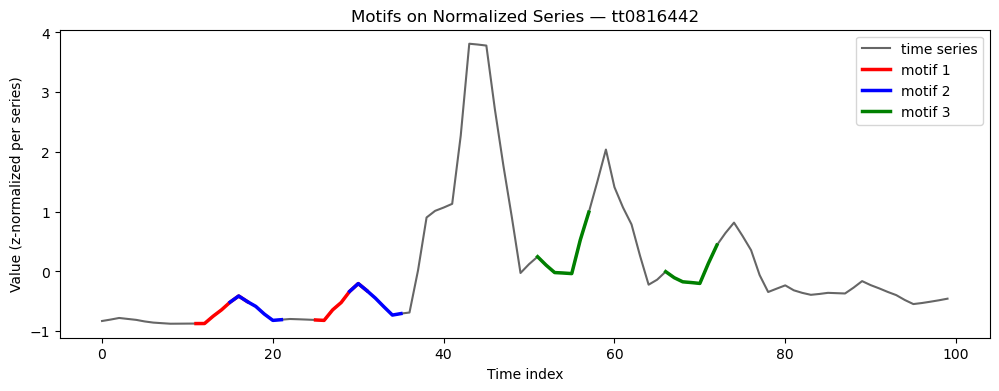

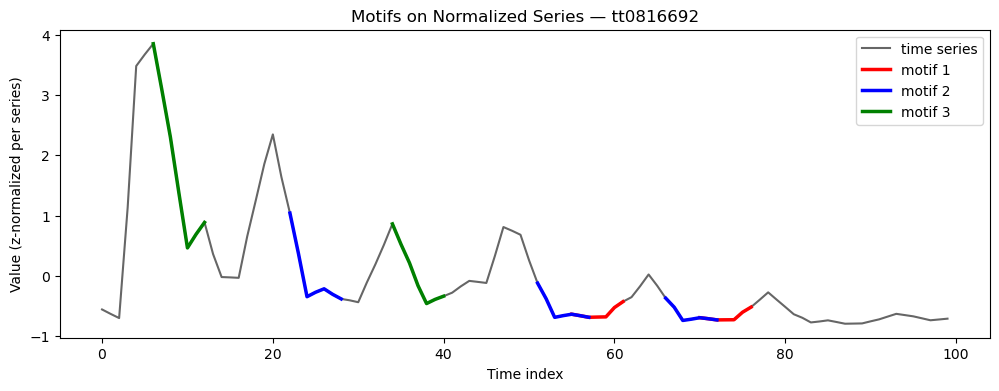

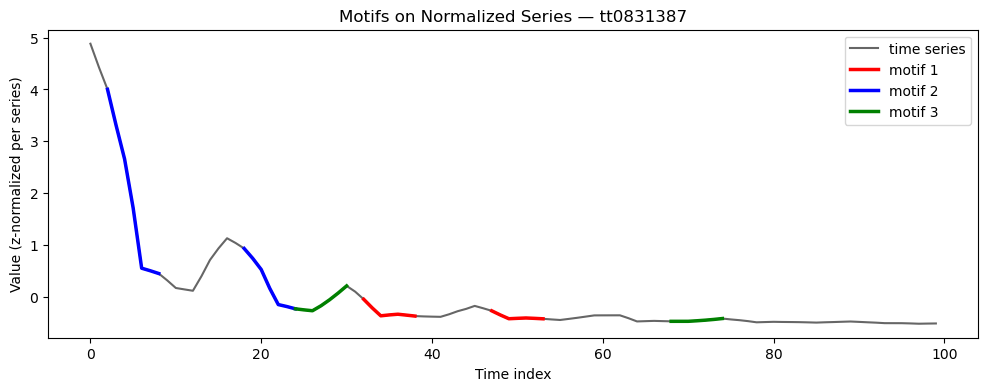

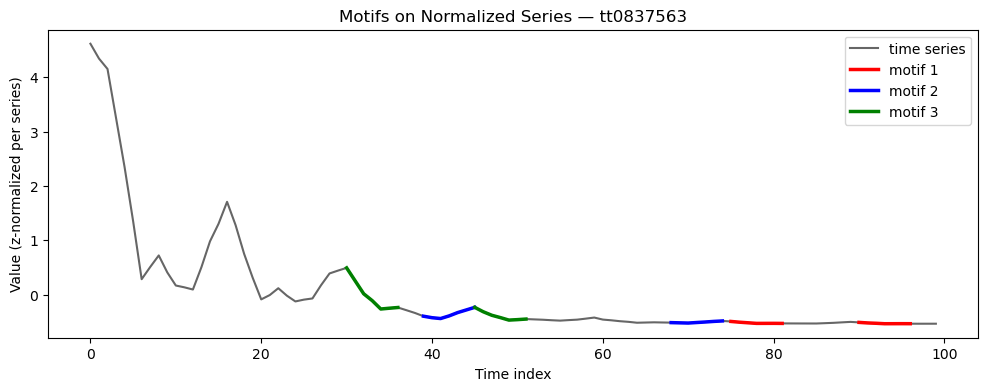

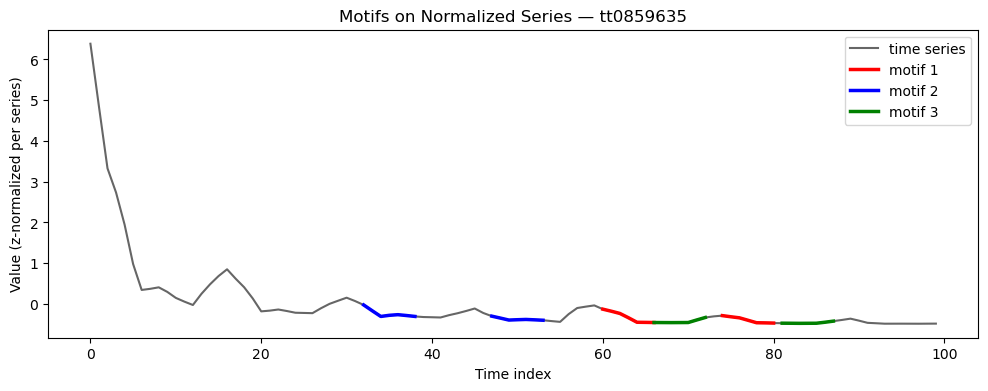

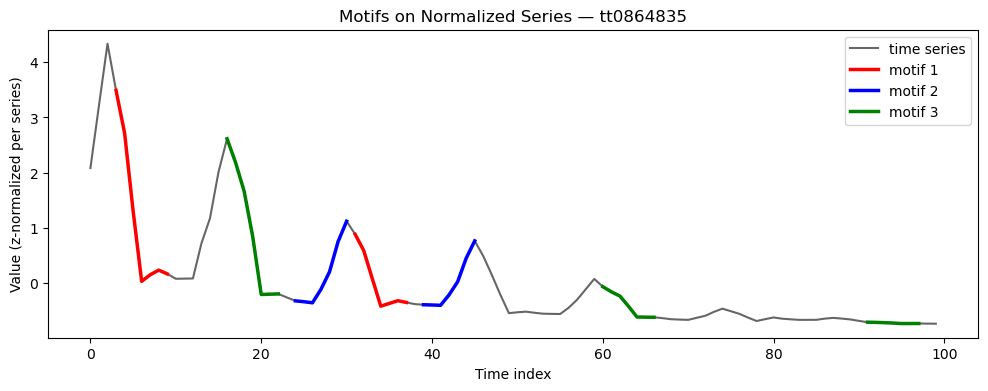

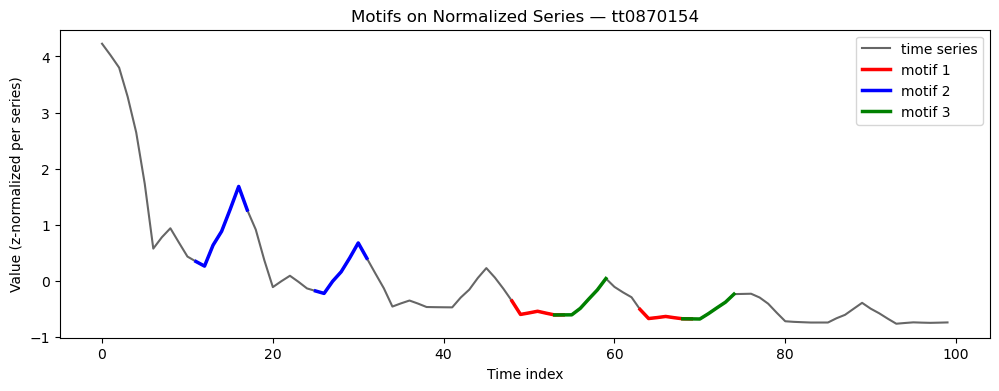

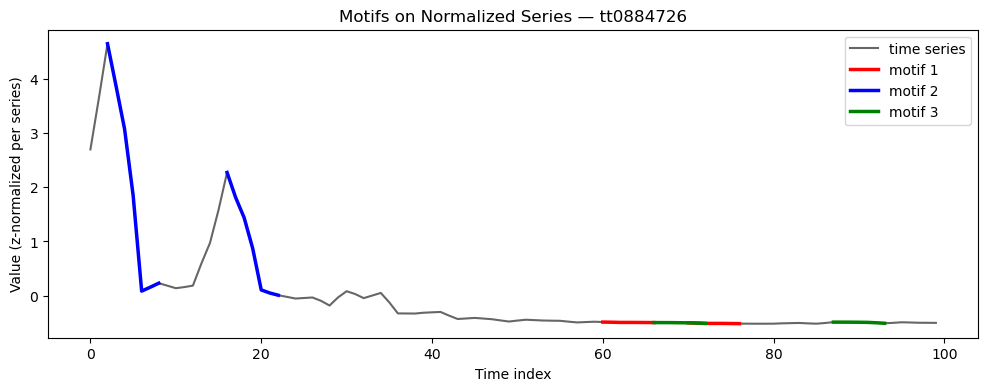

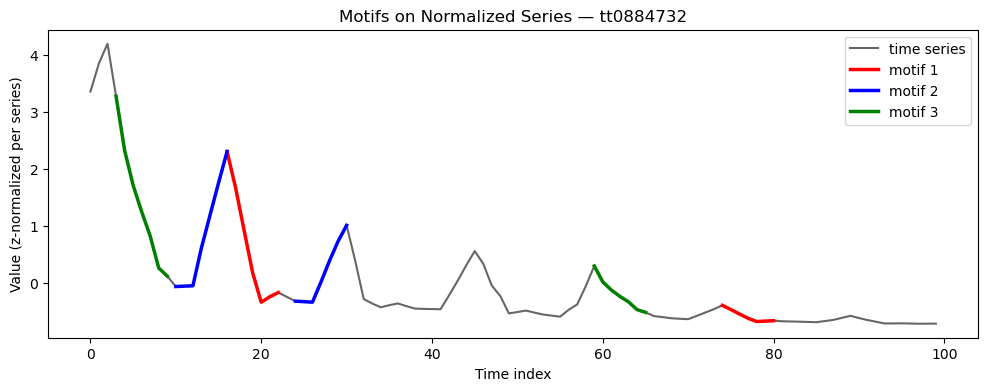

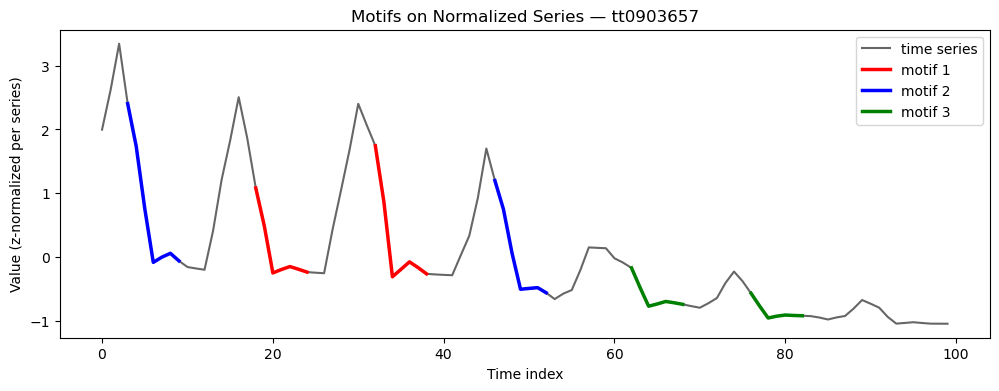

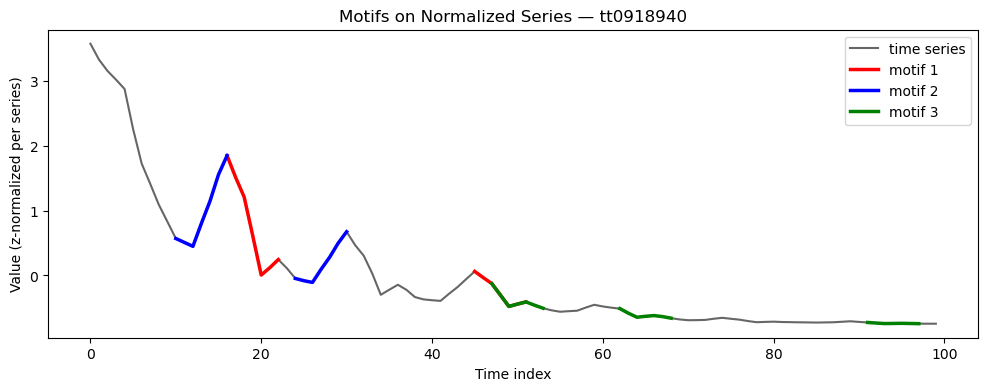

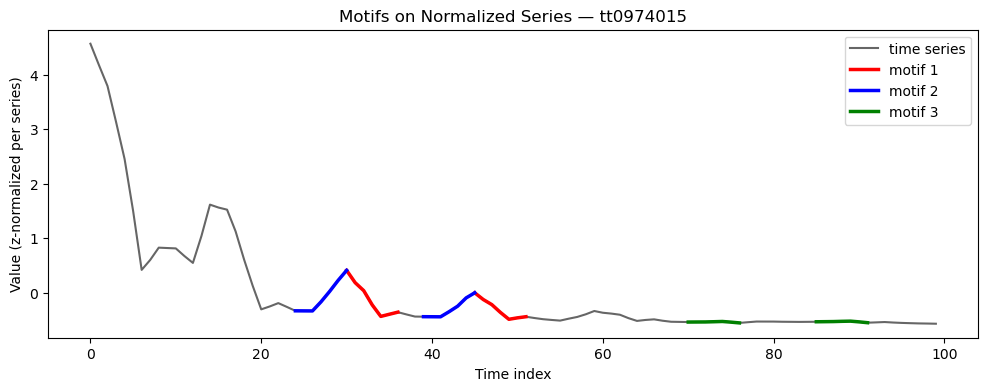

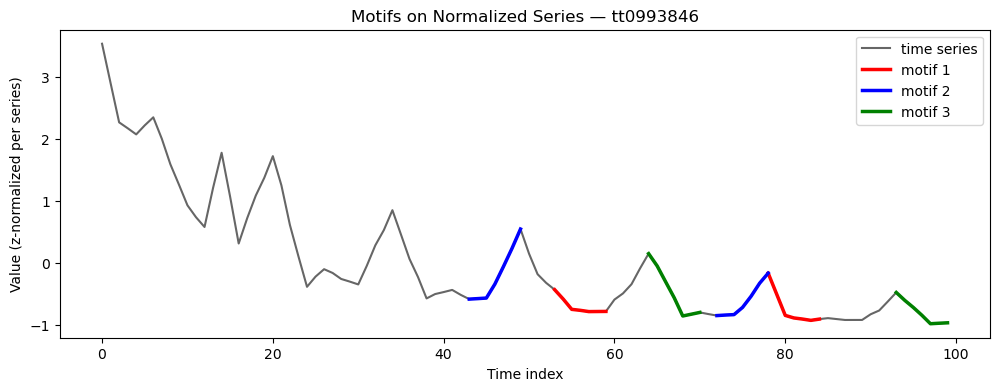

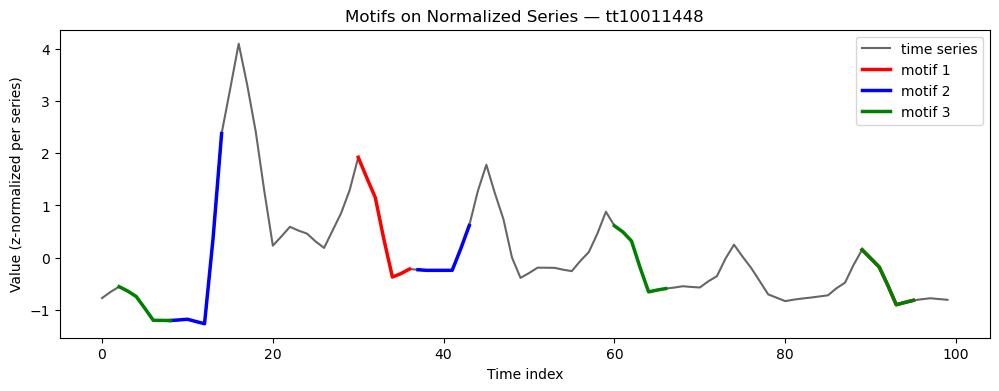

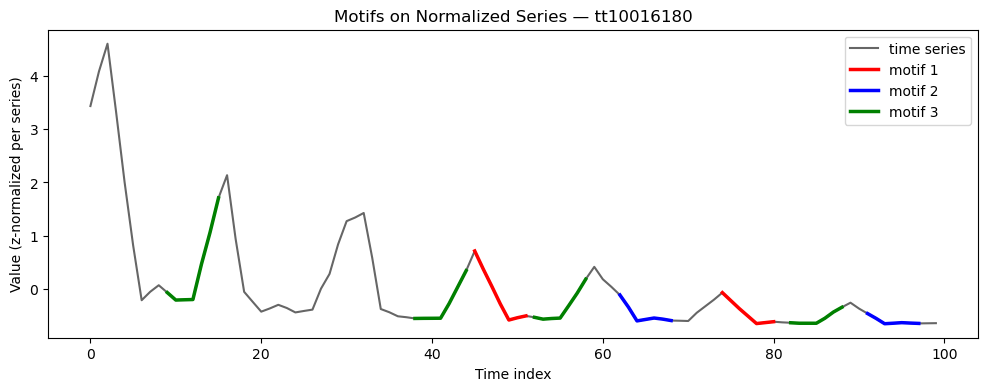

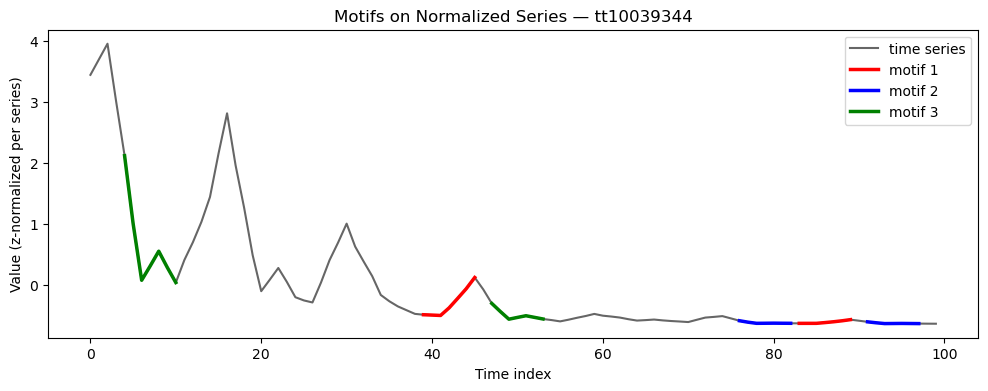

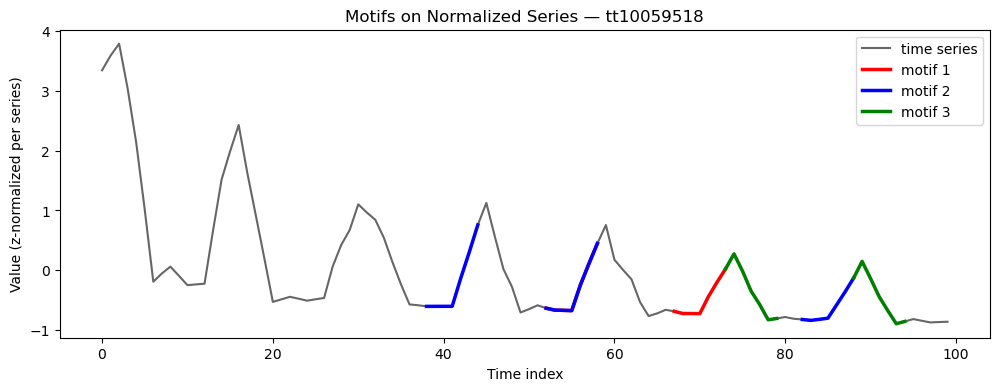

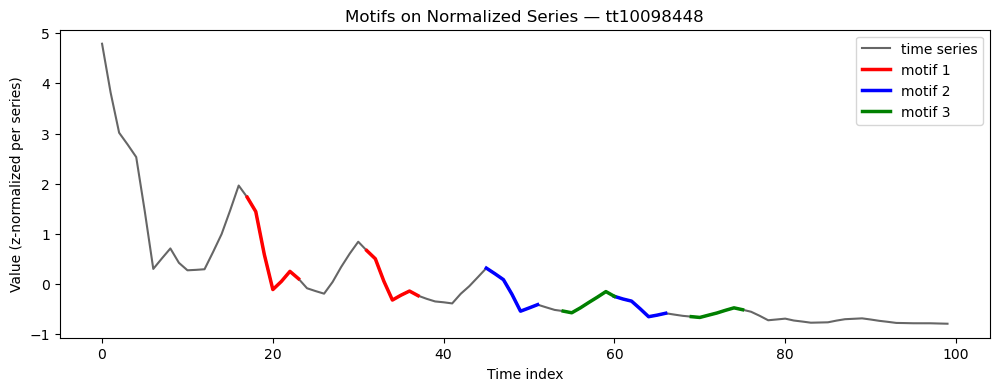

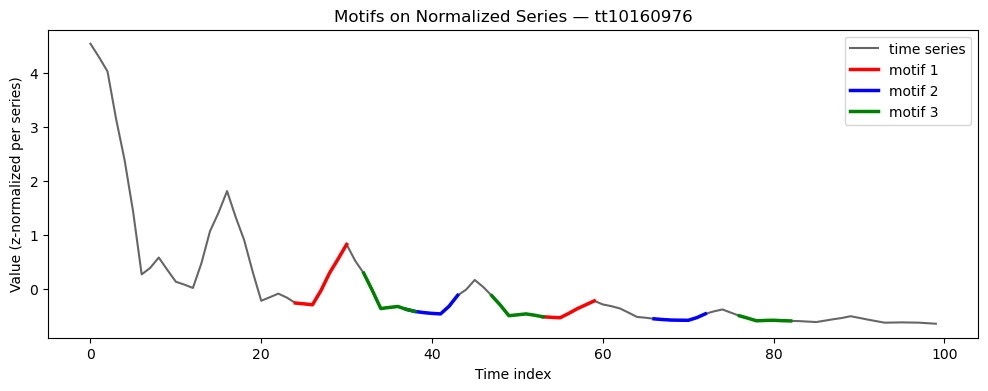

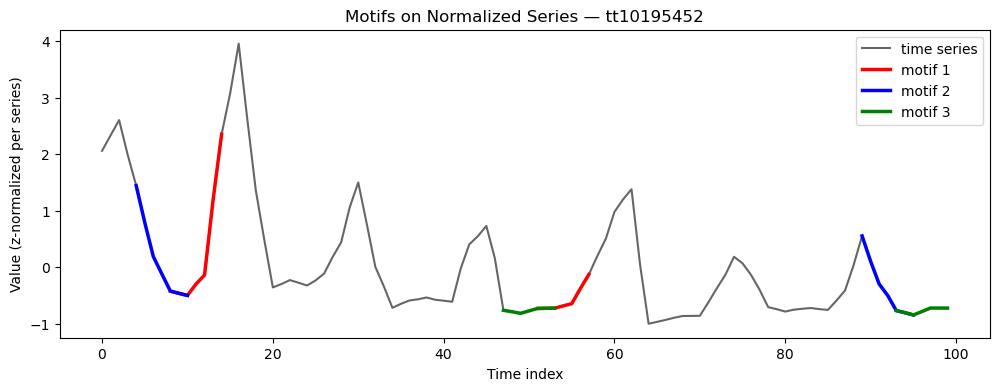

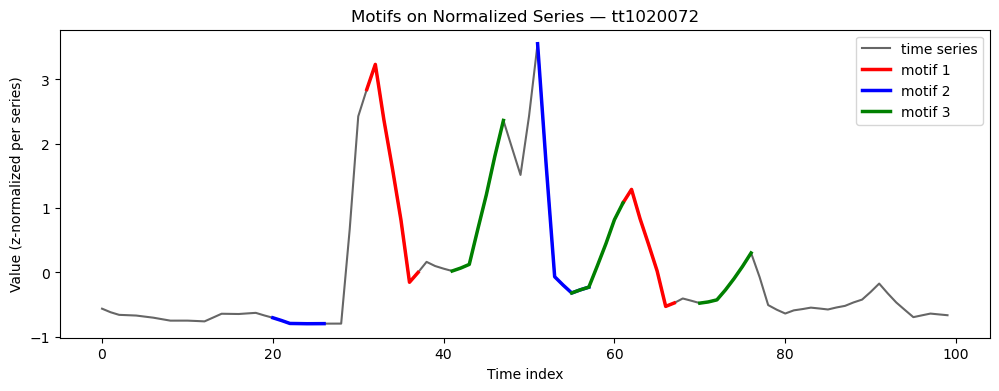

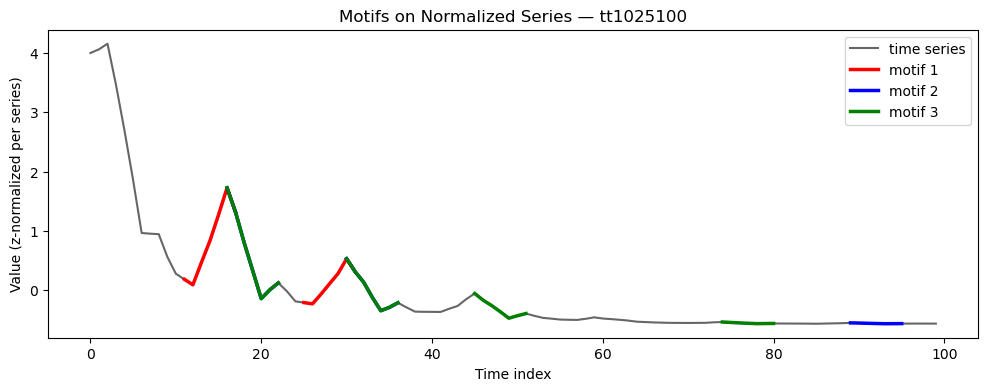

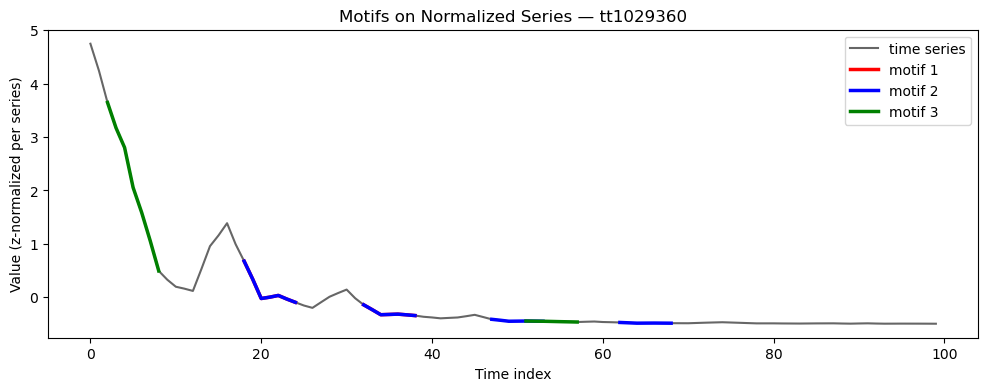

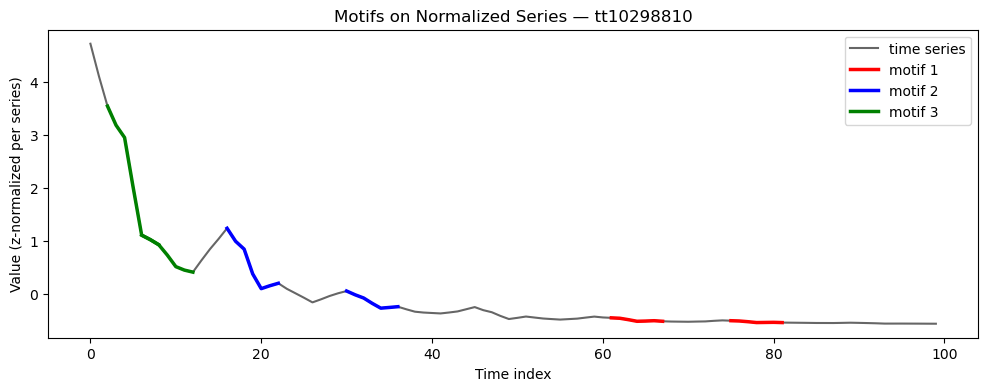

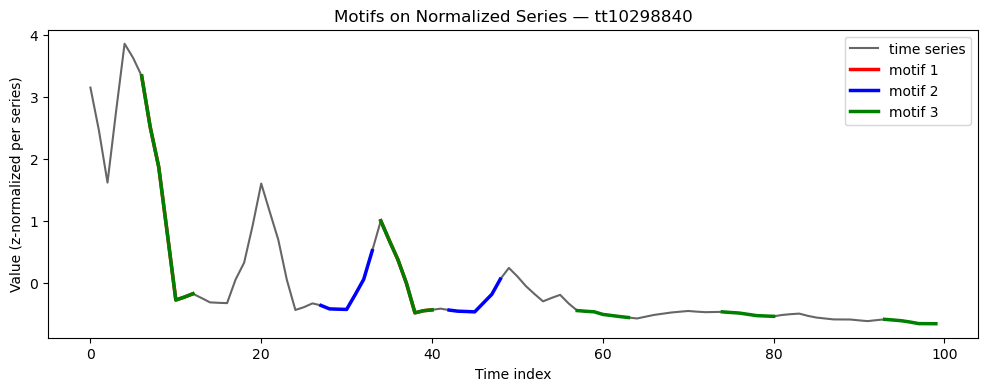

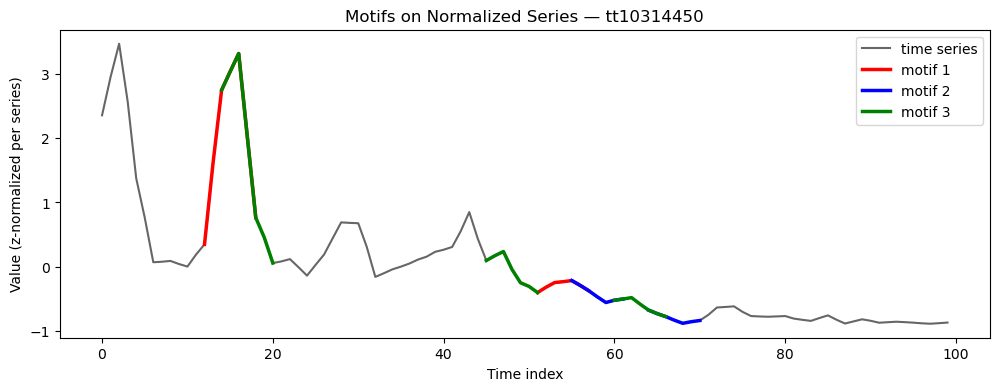

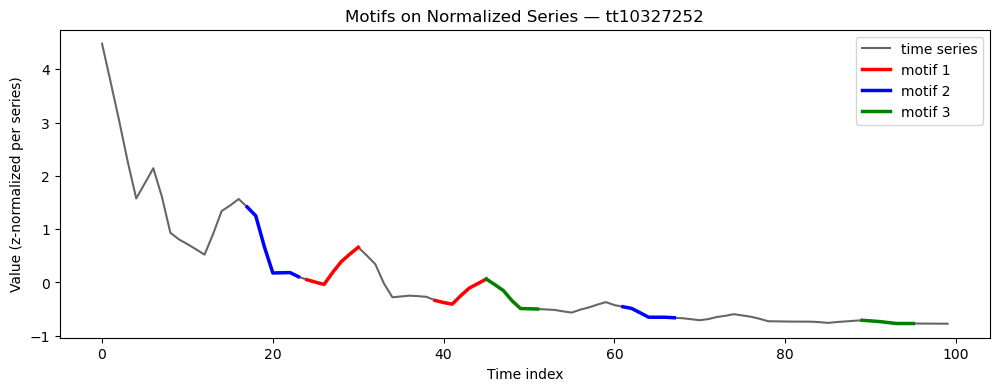

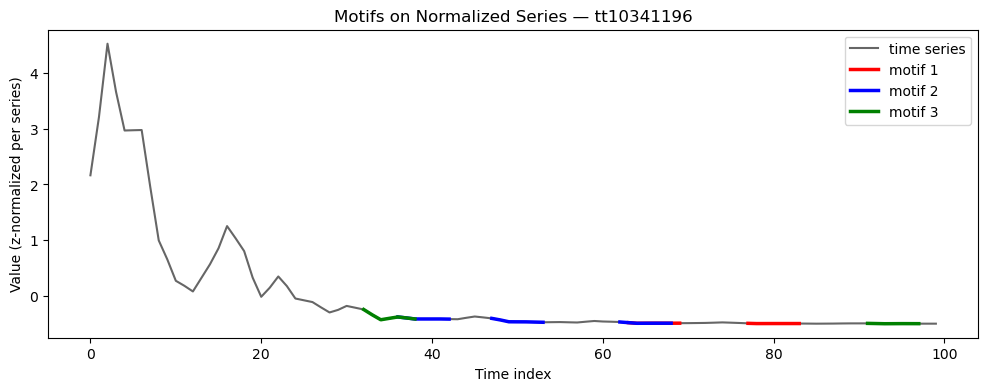

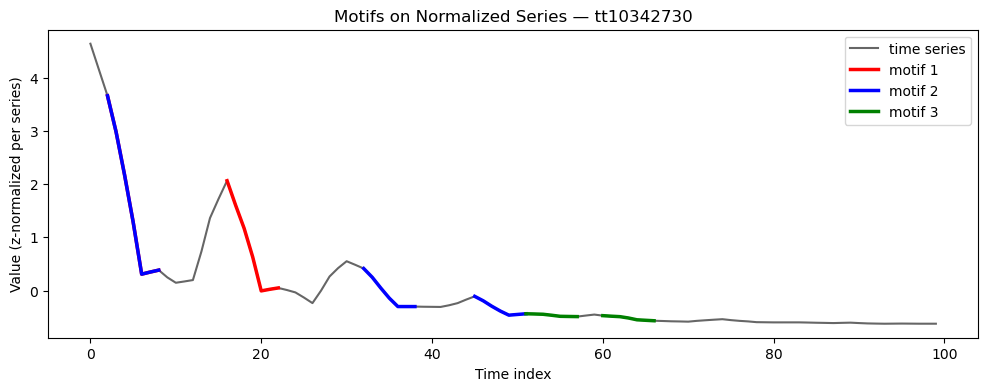

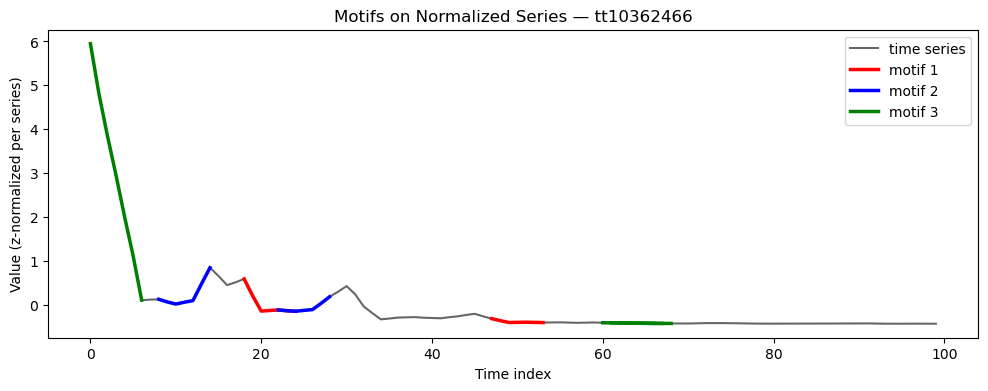

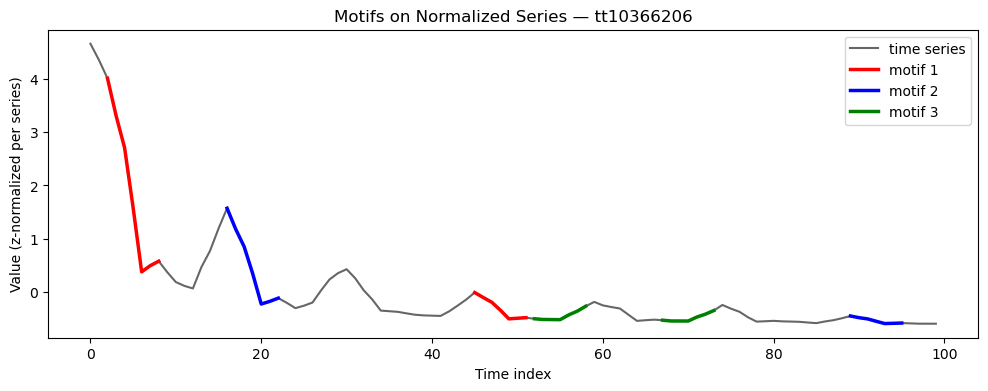

In [8]:
def plot_motifs_for_series(ts, motif_sets, m=7, title=None):
    plt.figure(figsize=(12, 4))
    plt.plot(ts, color="black", alpha=0.6, label="time series")
    colors = ["red", "blue", "green"]
    
    for k_idx, motif in enumerate(motif_sets[:3]):
        c = colors[k_idx % len(colors)]
        label_added = False
        for start in motif["members"]:
            end = start + m
            plt.plot(range(start, end), ts[start:end], color=c, linewidth=2.5,
                     label=f"motif {k_idx+1}" if not label_added else "")
            label_added = True
    
    if title:
        plt.title(title)
    plt.xlabel("Time index")
    plt.ylabel("Value (z-normalized per series)")
    plt.legend()
    plt.show()

# Re-plot first 3 normalized series with corrected labels
for i in range(50):
    ts = df_norm.iloc[i][value_cols].values.astype(float)
    plot_motifs_for_series(ts, all_results[ids[i]], m=m, title=f"Motifs on Normalized Series — {ids[i]}")


In [9]:
import ast

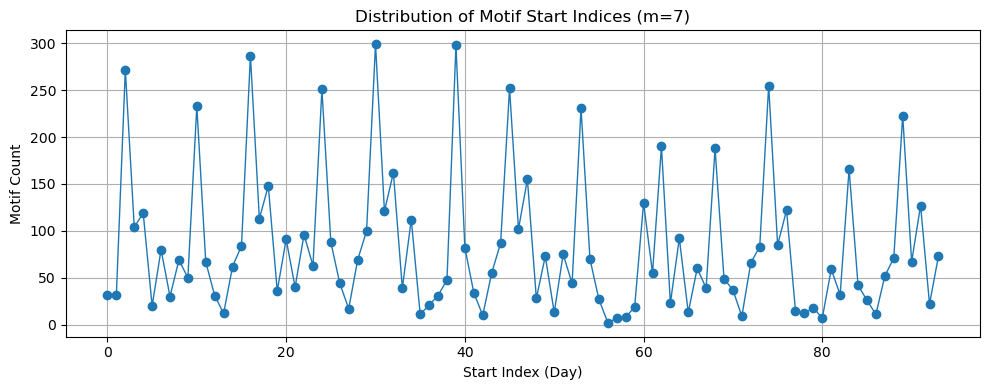

In [10]:

motifs_df = pd.read_csv("motifs_df.csv")

# Parse motif columns as lists
for col in ["motif1_members", "motif2_members", "motif3_members"]:
    motifs_df[col] = motifs_df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Count motif start indices across all motifs
motif_start_counts = np.zeros(94, dtype=int)  # 100 - 7 + 1 = 94
for col in ["motif1_members", "motif2_members", "motif3_members"]:
    for members in motifs_df[col]:
        for idx in members:
            if 0 <= idx < 94:
                motif_start_counts[idx] += 1

# Plot the distribution
plt.figure(figsize=(10, 4))
plt.plot(range(94), motif_start_counts, marker='o', linewidth=1)
plt.title("Distribution of Motif Start Indices (m=7)")
plt.xlabel("Start Index (Day)")
plt.ylabel("Motif Count")
plt.grid(True)
plt.tight_layout()
plt.show()

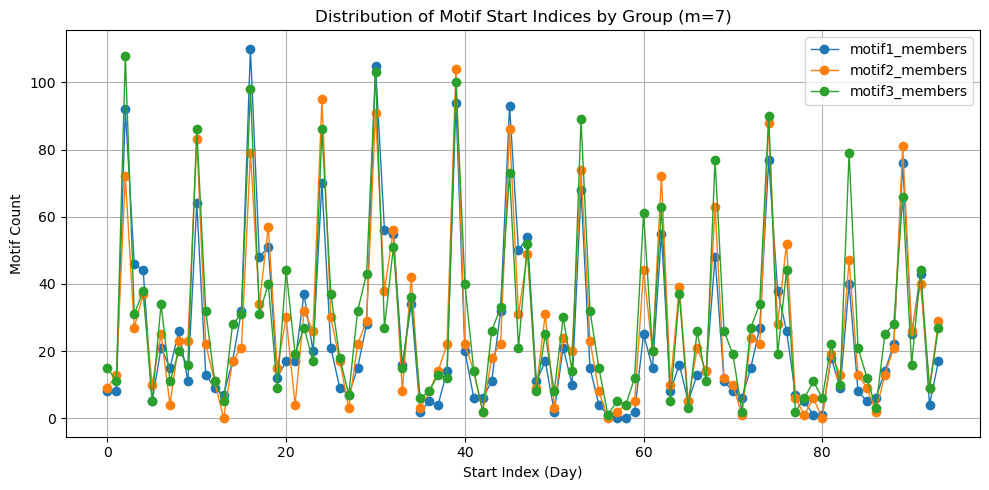

In [11]:
motif_groups = ["motif1_members", "motif2_members", "motif3_members"]

# Store counts per group
motif_start_counts_by_group = {g: np.zeros(94, dtype=int) for g in motif_groups}

for g in motif_groups:
    for members in motifs_df[g]:
        for idx in members:
            if 0 <= idx < 94:
                motif_start_counts_by_group[g][idx] += 1

# Plot all groups together
plt.figure(figsize=(10, 5))
for g in motif_groups:
    plt.plot(range(94), motif_start_counts_by_group[g], marker='o', linewidth=1, label=g)

plt.title("Distribution of Motif Start Indices by Group (m=7)")
plt.xlabel("Start Index (Day)")
plt.ylabel("Motif Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
motif_count_per_day = pd.DataFrame({
    "day": np.arange(94),
    "motif_count": motif_start_counts
})

motif_count_per_day.value_counts()

day  motif_count
0    32             1
59   19             1
68   188            1
67   39             1
66   60             1
                   ..
29   100            1
28   69             1
27   17             1
26   44             1
93   73             1
Name: count, Length: 94, dtype: int64

# Comparing with Shapelets

In [13]:
import pandas as pd
import numpy as np

In [14]:
motifs_discords = pd.read_csv('motifs_df.csv')
shapelets = np.load('shapelets.npy', allow_pickle=True)
shapelets_df = pd.read_csv('shapelets.csv')

In [15]:
shapelets.shape

(793, 146)

In [16]:
shapelets

array([[1.24636725, 0.12792638, 0.26703136, ..., 0.30188372, 0.05939054,
        0.22977684],
       [1.01092271, 0.18047597, 0.18703731, ..., 0.16864791, 0.07492591,
        0.11050806],
       [0.35529628, 0.12755727, 0.11912529, ..., 0.03895523, 0.11165695,
        0.14609612],
       ...,
       [0.81608966, 0.37613573, 0.46110741, ..., 0.20930881, 0.12670105,
        0.09555458],
       [0.69558295, 0.16412557, 0.22355993, ..., 0.05786255, 0.1151345 ,
        0.10831951],
       [0.60907888, 0.20799288, 0.28235524, ..., 0.02474244, 0.12509944,
        0.04908365]])

In [17]:
motifs_discords

id motif1_seed motif1_members motif2_seed   motif2_members  \
0     tt0062622     (3, 31)        [3, 31]    (41, 55)         [41, 55]   
1     tt0064816    (41, 70)       [41, 70]     (3, 29)          [3, 29]   
2     tt0088178    (28, 43)       [28, 43]    (16, 89)     [16, 30, 89]   
3     tt0145487    (51, 81)    [8, 51, 81]    (22, 66)     [22, 37, 66]   
4     tt0359950    (64, 93)       [64, 93]    (55, 70)         [55, 70]   
...         ...         ...            ...         ...              ...   
1129  tt9731534     (3, 75)        [3, 75]    (18, 47)  [4, 18, 47, 76]   
1130  tt9735462     (8, 22)        [8, 22]    (81, 93)         [81, 93]   
1131  tt9764362     (3, 17)        [3, 17]    (25, 40)         [25, 40]   
1132  tt9784798    (26, 85)       [26, 85]    (18, 32)         [18, 32]   
1133  tt9883996    (20, 62)       [20, 62]    (30, 45)         [30, 45]   

     motif3_seed motif3_members  
0       (10, 47)   [10, 47, 91]  
1       (16, 47)       [16, 47]  
2       (49, 81)       [49, 81]  
3       (43, 87)       [43, 87]  
4       (21, 80)   [21, 65, 80]  
...          ...            ...  
1129    (12, 70)       [12, 70]  
1130     (1, 15)        [1, 15]  
1131    (29, 44)       [29, 44]  
1132    (37, 51)       [37, 51]  
1133    (53, 83)       [53, 83]  

[1134 rows x 7 columns]

In [18]:
shapelets_df

gain  length  start_position  dimension  index  rating_category  \
0    0.080819      18              29          0    163                3   
1    0.079733      20              53          0    747                3   
2    0.078786      20              27          0    314                3   
3    0.077191      20              44          0    574                3   
4    0.076916      15               2          0    604                3   
..        ...     ...             ...        ...    ...              ...   
291  0.012296      18              44          0     46                2   
292  0.012296      14              59          0     43                2   
293  0.012280      15              61          0    694                2   
294  0.011985       9              39          0    741                2   
295  0.011706       8              78          0    764                2   

                                              shapelet  
0    [-2.28489334 -2.38254585 -0.47629627  1.548660...  
1    [-1.82262799 -1.90122555 -1.977249   -0.932223...  
2    [-1.40468547 -1.22435973 -1.67208099 -2.183064...  
3    [ 2.17096091  2.5362069   1.8582426   0.984555...  
4    [-0.23873281 -0.19176907 -0.15501366 -0.448570...  
..                                                 ...  
291  [-1.55224059 -1.52519144 -0.64330952  0.442095...  
292  [ 2.31109756  1.52109439  1.1687022   0.853006...  
293  [ 1.97449546  1.64506379  0.18685574 -1.017204...  
294  [-0.96456489 -1.05096974 -1.12696084 -0.652659...  
295  [-0.33893058  0.50399769  1.57291506  0.810508...  

[296 rows x 7 columns]

In [19]:
shapelets_df.to_csv('shapelets_df.csv', index=False)

In [20]:
shapelets_df.length.value_counts()

length
20    61
18    39
17    32
19    31
16    25
15    19
7     14
14    13
8     13
12    11
9     11
10    11
11     9
13     7
Name: count, dtype: int64

In [21]:
shapelets_df.start_position.value_counts().head(20)

start_position
29    12
45    11
44     9
32     8
73     8
2      7
46     7
17     7
1      6
22     6
3      6
60     6
33     6
43     6
18     6
76     5
49     5
14     5
47     5
66     5
Name: count, dtype: int64

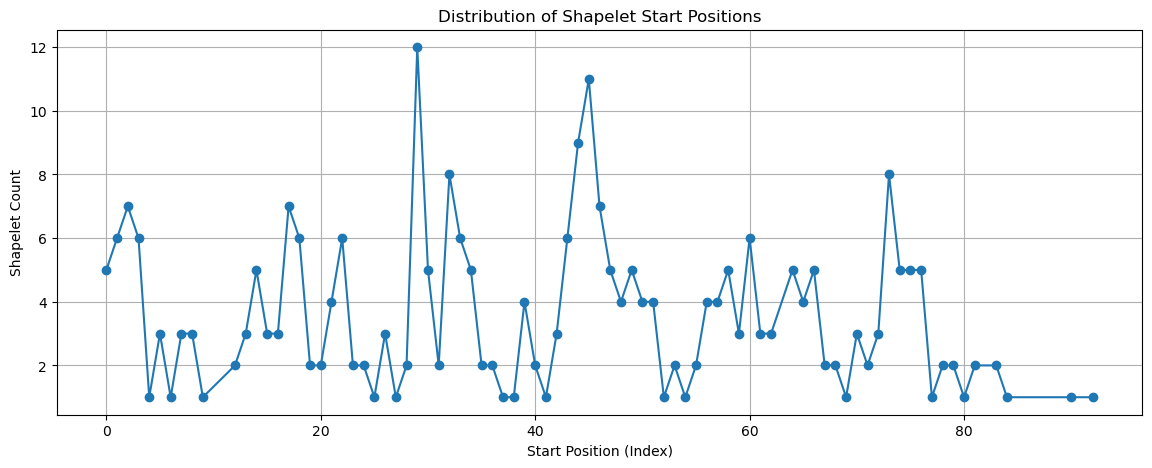

In [22]:
# Plot distribution of shapelet start positions as line chart
start_counts = shapelets_df['start_position'].value_counts().sort_index()

plt.figure(figsize=(14, 5))
plt.plot(start_counts.index, start_counts.values, marker='o')
plt.title("Distribution of Shapelet Start Positions")
plt.xlabel("Start Position (Index)")
plt.ylabel("Shapelet Count")
plt.grid(True)
plt.show()


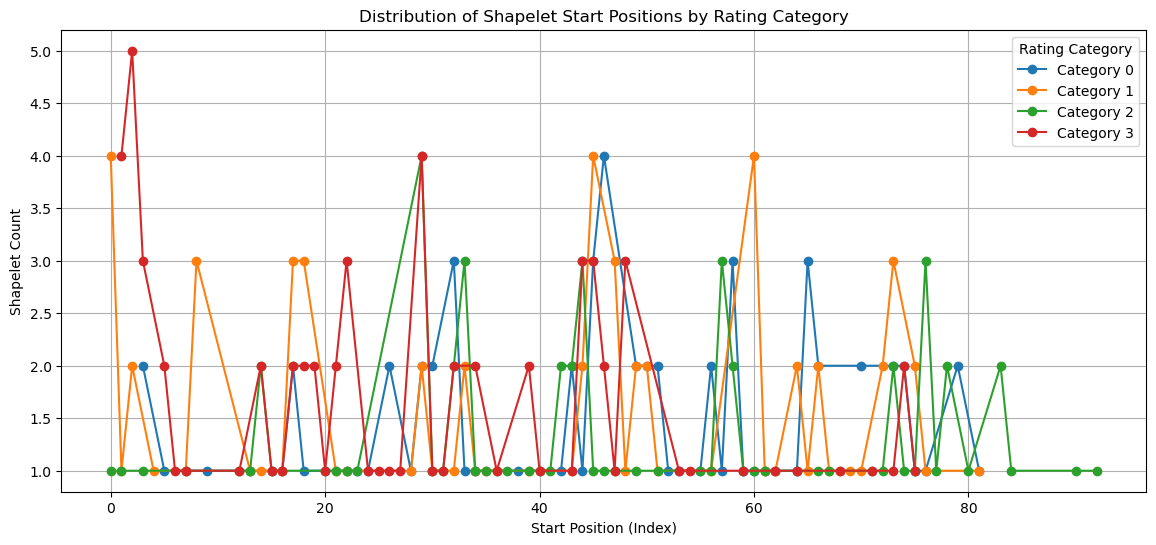

In [23]:
plt.figure(figsize=(14, 6))

# Group counts by category and start position
for category, group in shapelets_df.groupby("rating_category"):
    start_counts = group['start_position'].value_counts().sort_index()
    plt.plot(start_counts.index, start_counts.values, marker='o', label=f"Category {category}")

plt.title("Distribution of Shapelet Start Positions by Rating Category")
plt.xlabel("Start Position (Index)")
plt.ylabel("Shapelet Count")
plt.legend(title="Rating Category")
plt.grid(True)
plt.show()


In [24]:
df = shapelets_df

In [26]:
import re

C:\Users\hiend\AppData\Local\Temp\ipykernel_20604\3121521847.py:10: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  arr = np.fromstring(s, sep=",")
C:\Users\hiend\AppData\Local\Temp\ipykernel_20604\3121521847.py:33: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  arr = np.fromstring(s, sep=",")


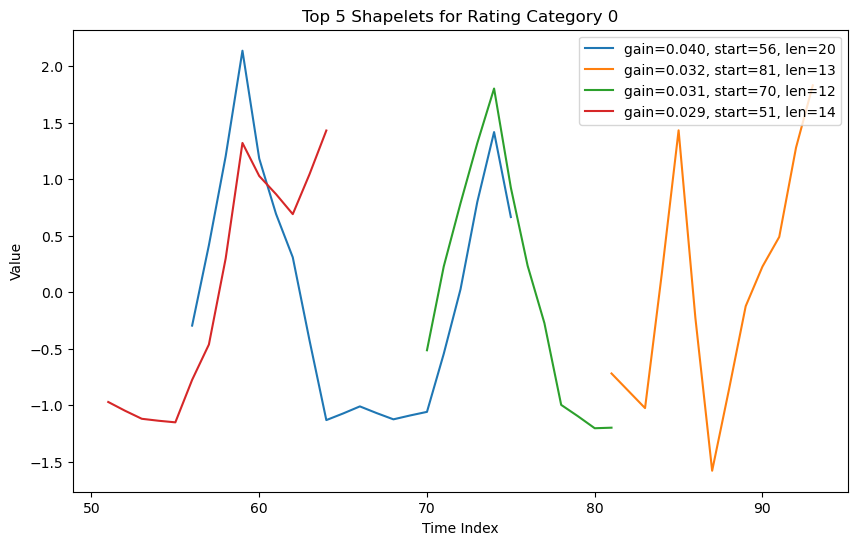

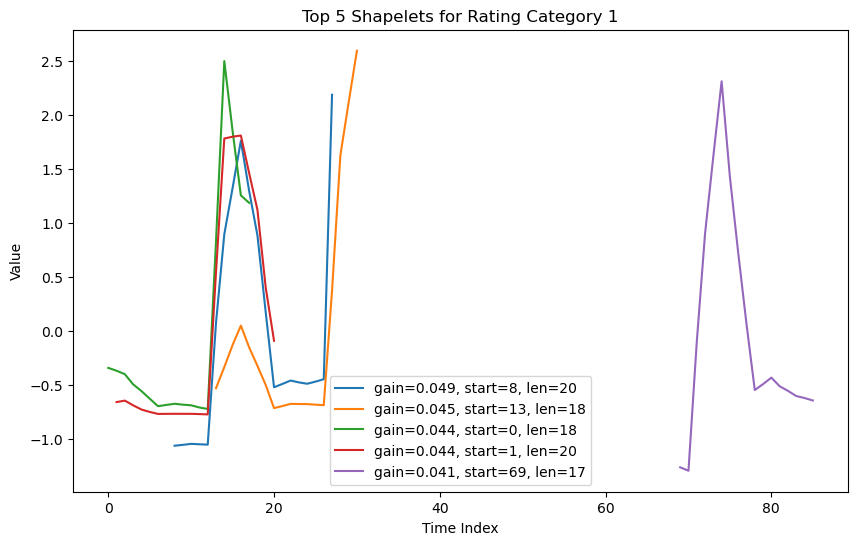

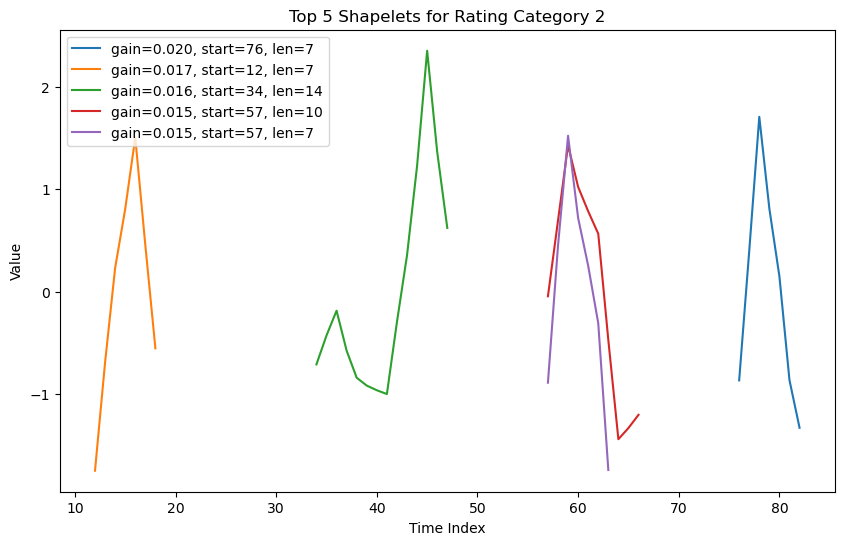

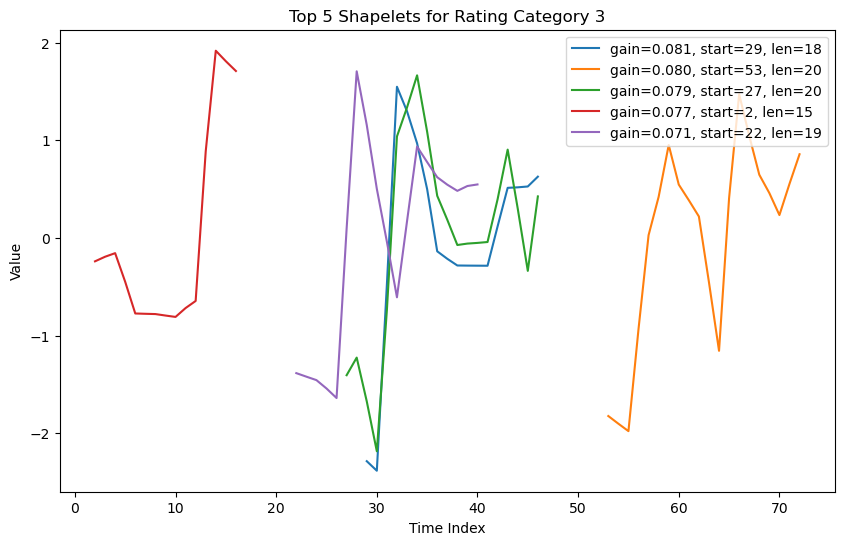

In [ ]:
# Improved parser with cleaning
def robust_parse_shapelet(s):
    # Replace multiple spaces with commas
    s = re.sub(r"\s+", ",", s.strip())
    # Remove double commas if any
    s = re.sub(r",,", ",", s)
    # Remove leading/trailing brackets
    s = s.strip("[]")
    # Convert to numpy array
    arr = np.fromstring(s, sep=",")
    return arr if len(arr) > 0 else np.nan

# Apply and drop invalid ones
df['parsed_shapelet'] = df['shapelet'].apply(robust_parse_shapelet)
df_valid = df.dropna(subset=['parsed_shapelet'])

# Select top 5 by gain for each category
top_shapelets = (
    df_valid.sort_values(by="gain", ascending=False)
            .groupby("rating_category")
            .head(5)
)

# Plot top 5 shapelets per category
for cat in sorted(df_valid['rating_category'].unique()):
    subset = top_shapelets[top_shapelets['rating_category'] == cat]
    plt.figure(figsize=(10,6))
    for i, row in subset.iterrows():
        shape = row['parsed_shapelet']
        start = row['start_position']
        length = row['length']
        gain = row['gain']
        
        plt.plot(range(start, start+len(shape)), shape, 
                 label=f"gain={gain:.3f}, start={start}, len={length}")
    
    plt.title(f"Top 5 Shapelets for Rating Category {cat}")
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


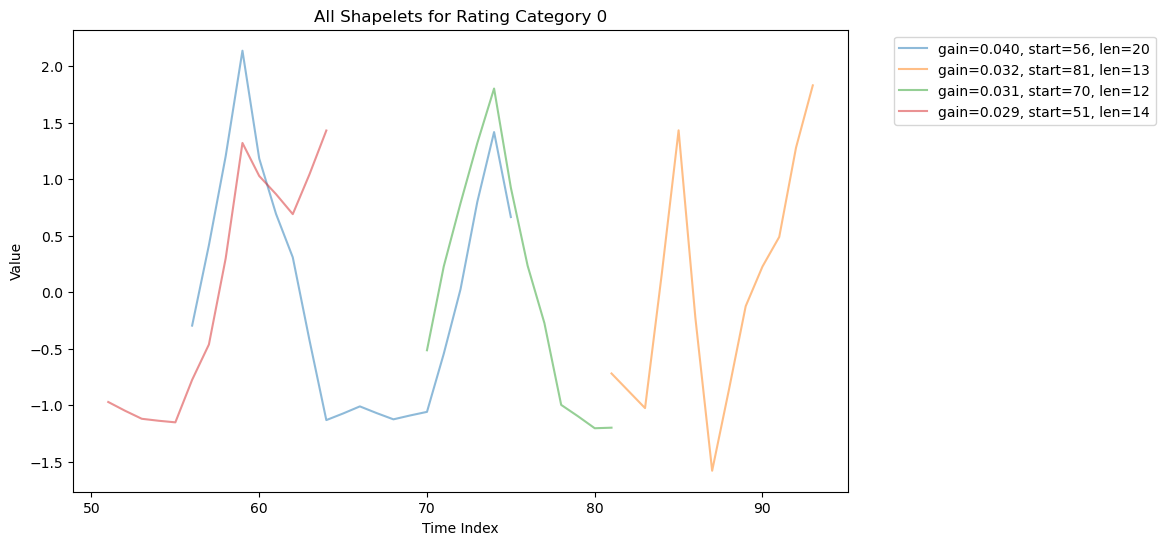

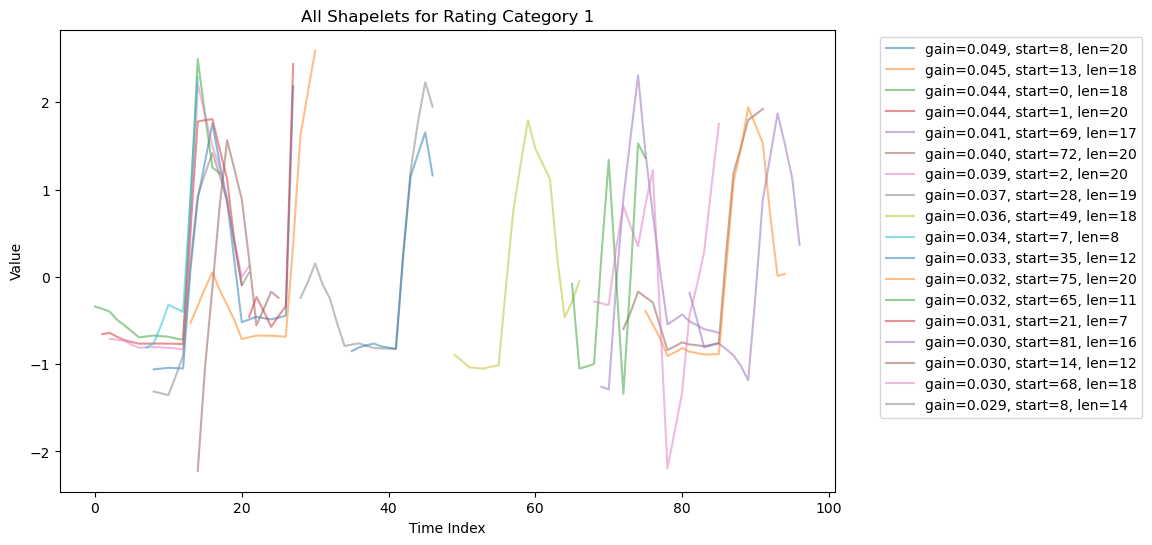

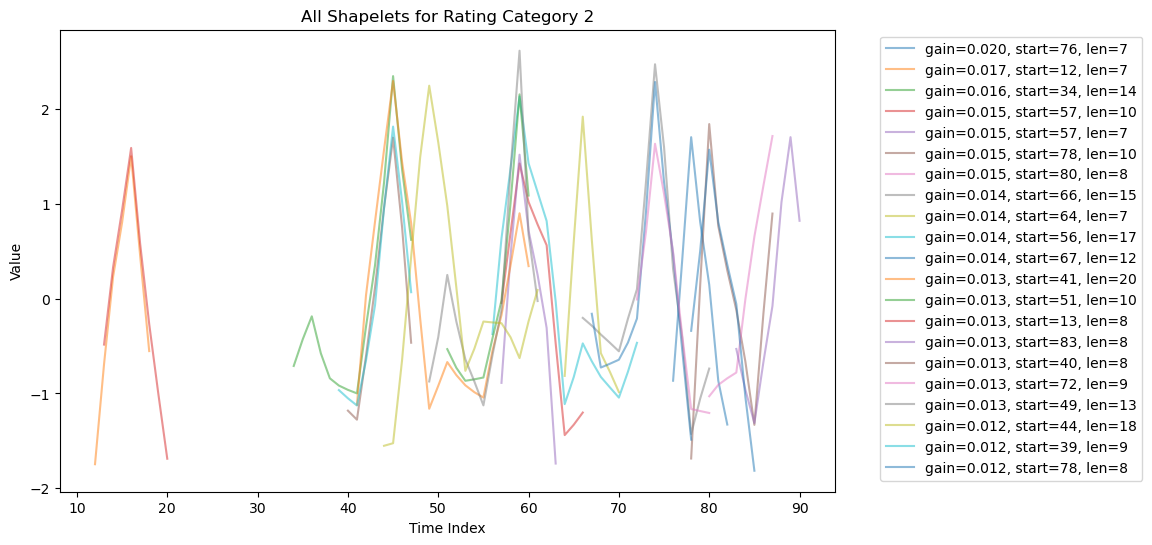

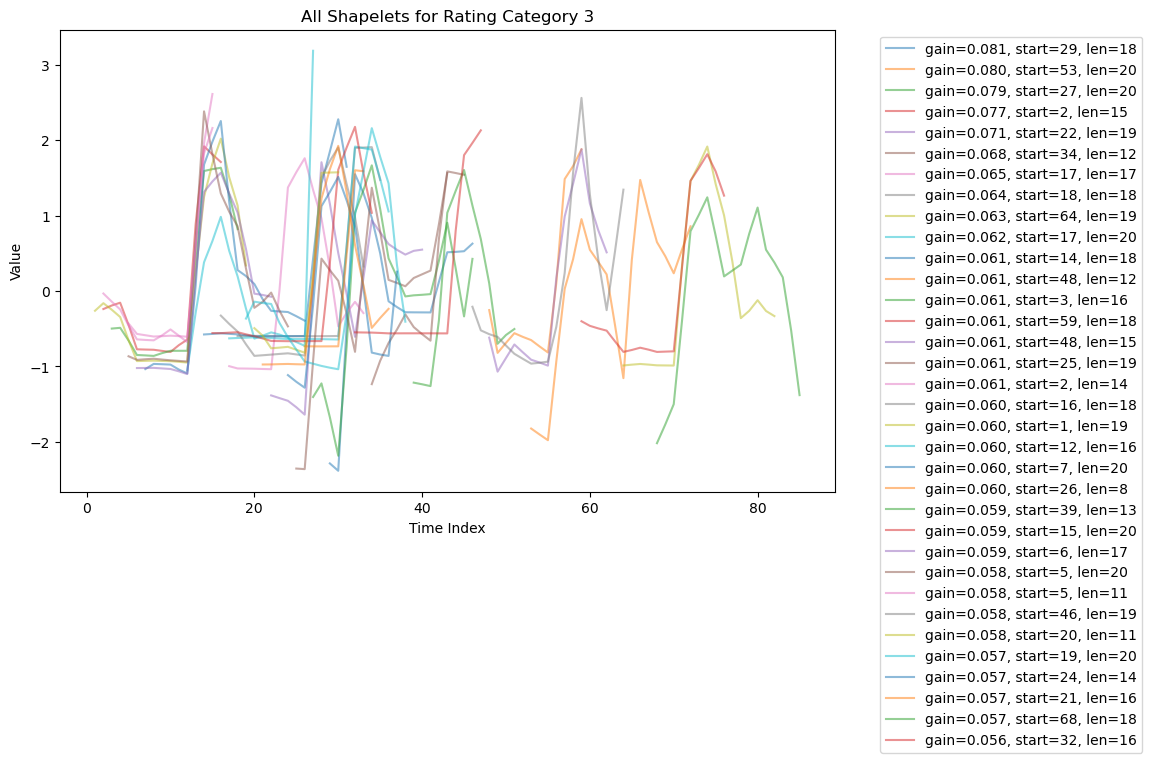

In [39]:
import matplotlib.pyplot as plt

# Loop through each category and plot ALL its shapelets
for cat, subset in df_valid.groupby("rating_category"):
    plt.figure(figsize=(10,6))
    for i, row in subset.iterrows():
        shape = row['parsed_shapelet']
        start = row['start_position']
        gain = row['gain']
        length = row['length']
        
        plt.plot(range(start, start+len(shape)), shape, alpha=0.5,
                 label=f"gain={gain:.3f}, start={start}, len={length}")
    
    plt.title(f"All Shapelets for Rating Category {cat}")
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")  # place legend outside
    plt.show()


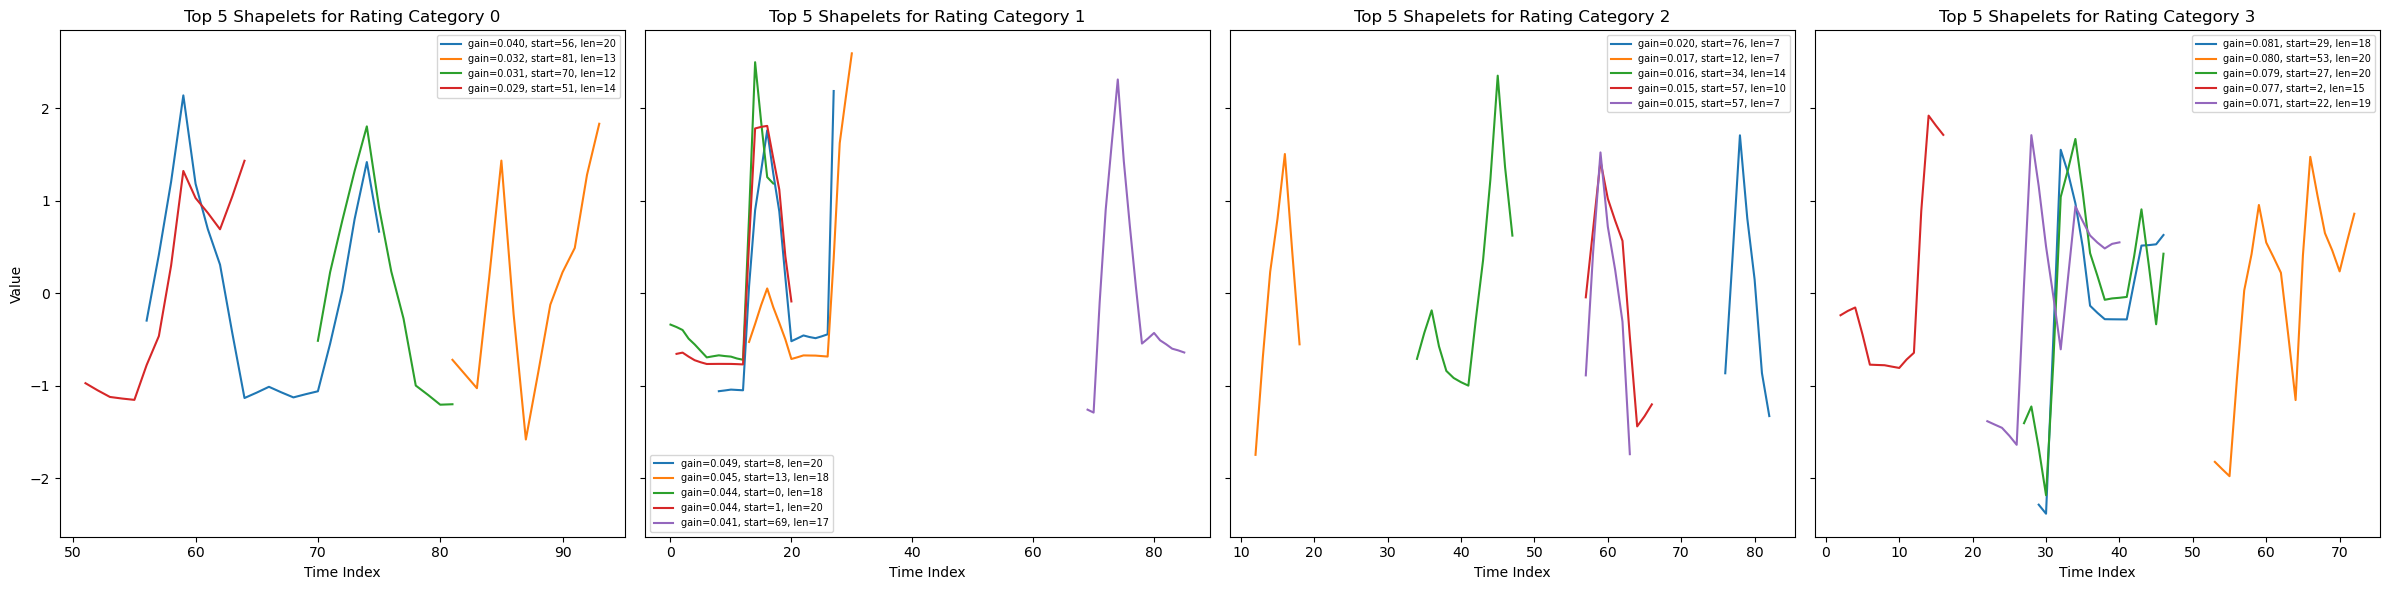

In [47]:
import matplotlib.pyplot as plt

# Create a grid with 1 row and 4 columns (one per category)
fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=True)

for ax, (cat, subset) in zip(axes, top_shapelets.groupby("rating_category")):
    for i, row in subset.iterrows():
        shape = row['parsed_shapelet']
        start = row['start_position']
        gain = row['gain']
        length = row['length']
        
        ax.plot(range(start, start+len(shape)), shape, alpha=1,
                label=f"gain={gain:.3f}, start={start}, len={length}")
    
    ax.set_title(f"Top 5 Shapelets for Rating Category {cat}")
    plt.xlabel("Time Index")
    ax.set_xlabel("Time Index")
    ax.legend(fontsize=7)

axes[0].set_ylabel("Value")  # only first plot gets y-axis label
plt.tight_layout()
plt.show()


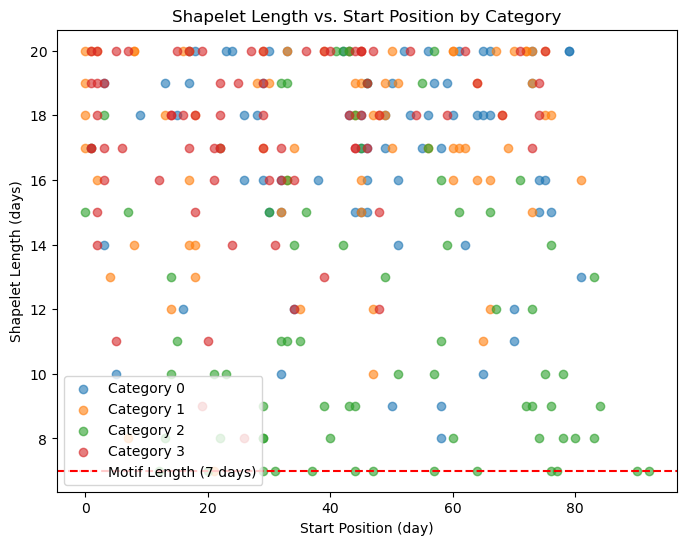

In [34]:
# Scatter plot: Shapelet length vs. start position, colored by rating category
plt.figure(figsize=(8,6))
for cat in sorted(shapelets_df['rating_category'].unique()):
    subset = shapelets_df[shapelets_df['rating_category'] == cat]
    plt.scatter(subset['start_position'], subset['length'], alpha=0.6, label=f"Category {cat}")

plt.axhline(y=7, color='red', linestyle='--', label="Motif Length (7 days)")
plt.title("Shapelet Length vs. Start Position by Category")
plt.xlabel("Start Position (day)")
plt.ylabel("Shapelet Length (days)")
plt.legend()
plt.show()